## Pull relevant drug target residues

### library and data path

In [1]:
library(tidyverse)
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
data_dir = file.path("~/bms-dms/sumstats")
list.files(data_dir)
# Load the data


[1] "TYK2-FLOW-flow-cleaned.midpoints.tsv"   
[2] "TYK2-run3-combined-cleaned.sumstats.tsv"
[3] "TYK2-run4-combined-cleaned.sumstats.tsv"
[4] "TYK2-run7-combined-cleaned.sumstats.tsv"
[5] "TYK2.contrast.tsv"

### re generate tabulated data

In [20]:
assay1 <- read_tsv("../sumstats/TYK2-run3-combined-cleaned.sumstats.tsv", show_col_types = FALSE) %>%
  mutate(assay = "assay1") %>% select(-version) %>%
  mutate(aa = if_else(aa %in% c("X", "Stop", "*"), "Stop", aa))

assay2 <- read_tsv("../sumstats/TYK2-run4-combined-cleaned.sumstats.tsv", show_col_types = FALSE) %>%
  mutate(assay = "assay2") %>% select(-version) %>%
  mutate(aa = if_else(aa %in% c("X", "Stop", "*"), "Stop", aa))

assay3 <- read_tsv("../sumstats/TYK2-run7-combined-cleaned.sumstats.tsv", show_col_types = FALSE) %>%
  mutate(assay = "assay3") %>% select(-version) %>%
  mutate(aa = if_else(aa %in% c("X", "Stop", "*"), "Stop", aa))

flow_data <- read_tsv("../sumstats/TYK2-FLOW-flow-cleaned.midpoints.tsv", show_col_types = FALSE) %>%
  mutate(aa = if_else(aa %in% c("X", "Stop", "*"), "Stop", aa))

assay_data <- bind_rows(assay1, assay2, assay3)  %>%
    group_by(assay) %>%
    mutate(fdr = p.adjust(p.value, method = "BH")) %>%
    ungroup()

treated <- assay_data %>% filter(condition != "None_0")
untreated <- assay_data %>%
  filter(condition == "None_0") %>%
  rename("log2FoldChange_Control" = "log2FoldChange",
         "log2StdError_Control" = "log2StdError") %>%
  select(-condition, -statistic, -p.value, -fdr)

sumstats <- inner_join(treated, untreated, by = c("chunk", "pos", "aa", "assay"))

In [3]:
contrast_sumstats <- read_tsv(file.path(data_dir, 'TYK2.contrast.tsv'))

Rows: 332371 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): chunk, condition, aa, assay
dbl (13): pos, log2FoldChange, log2StdError, statistic, p.value, fdr, log2Fo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
contrast_sumstats |> head()

chunk,pos,condition,aa,log2FoldChange,log2StdError,statistic,p.value,assay,fdr,log2FoldChange_Control,log2StdError_Control,log2Contrast,log2ContrastError,statistic_contrast,p.value_contrast,fdr_contrast
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,1051,IFNalpha_1,Stop,-0.32827896,0.5119714,-0.6412057,0.5213890442,assay1,0.83246901,0.5148870,0.5085672,-0.84316601,0.7216337,-1.16841266,0.242640353,0.77117824
16,1051,IFNalpha_10,Stop,-1.42526137,0.5963387,-2.3900198,0.0168474632,assay1,0.15664172,0.5148870,0.5085672,-1.94014841,0.7837477,-2.47547573,0.013305881,0.17362141
16,1051,IFNalpha_100,Stop,-1.91648342,0.5695281,-3.3650377,0.0007653319,assay1,0.01405539,0.5148870,0.5085672,-2.43137047,0.7635462,-3.18431348,0.001450978,0.02954594
16,1051,IFNalphaWithDrug_100,Stop,-0.16611366,0.5903476,-0.2813828,0.7784168280,assay1,0.93976436,0.5148870,0.5085672,-0.68100071,0.7791989,-0.87397544,0.382131630,0.86131371
16,1051,IFNbeta_100,Stop,0.49161868,0.4514839,1.0888952,0.2762000867,assay1,0.66716954,0.5148870,0.5085672,-0.02326836,0.6800576,-0.03421528,0.972705481,0.99692239
16,1051,IFNalpha_1,A,0.08283352,0.2762934,0.2998028,0.7643275941,assay1,0.93502902,0.3452057,0.2791116,-0.26237214,0.3927357,-0.66806297,0.504093400,0.91051558


### find data that are related to drug resistance and potentiation

In [4]:
bms_resist <- contrast_sumstats %>%
    filter(assay == "assay1", condition == "IFNalphaWithDrug_100")

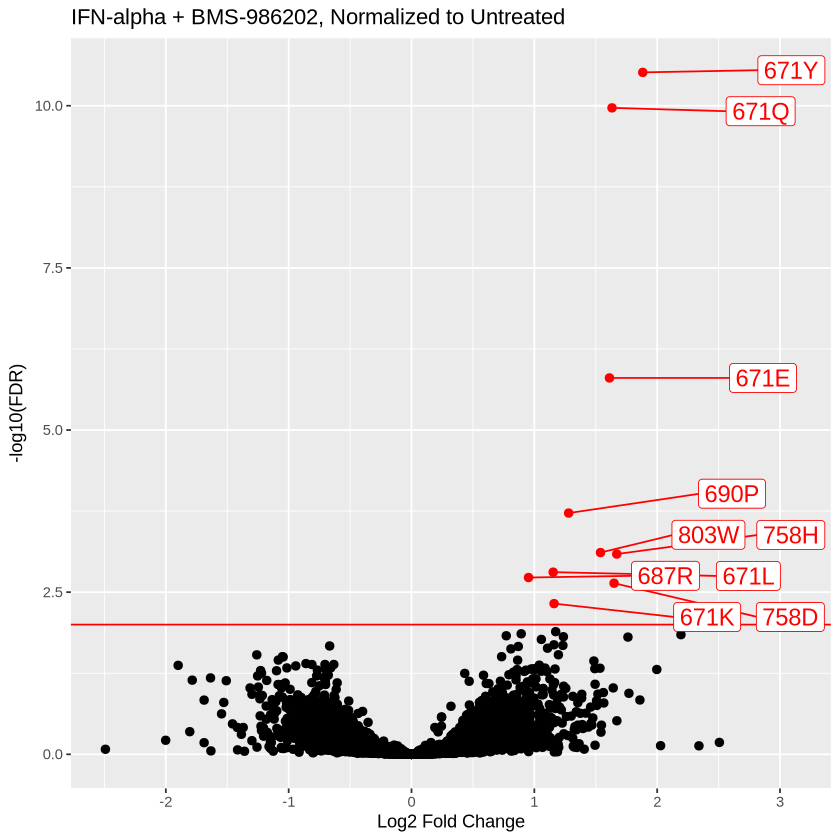

In [7]:
ggplot(bms_resist) +
    geom_hline(yintercept = -log10(0.01), color = "red") +
    geom_point(aes(x = log2Contrast,
                   y = -log10(fdr_contrast),
                   color = if_else(fdr_contrast < 0.01, "red", "black")),
               size = 2) +
    geom_label_repel(data = bms_resist %>% filter(fdr_contrast < 0.01),
                     aes(x = log2Contrast,
                         y = -log10(fdr_contrast),
                         color = if_else(fdr_contrast < 0.01, "red", "black"),
                         label = str_c(pos, aa)),
                     size = 5, nudge_x = 1.25) +
    xlab("Log2 Fold Change") + ylab("-log10(FDR)") +
    scale_color_identity() +
    ggtitle("IFN-alpha + BMS-986202, Normalized to Untreated")

In [14]:
colors <- c("Neither" = "gray",
            "Both" = "purple",
            "BMS-986202" = "red",
            "Zasocitinib" = "blue")

aa_order <- c("G","A","P","K","H",
              "R","T","S","C","E",
              "D","M","V","I","L",
              "Y","W","F","Q","N")

source("../src/model_utils.R")

plot_chemical_footprint <- function(data) {

    to_return <- data %>%
        ggplot(aes(text = str_c(pos, aa))) +
        geom_tile(aes(x = as.factor(pos),
                      y = fct_rev(aa),
                      fill = `FDR < 0.01`)) +
        scale_fill_manual(values = colors) +
        xlab("Position") + ylab("") +
        facet_grid(scale = "free_x",
                   space = "free")

    return(to_return)
}

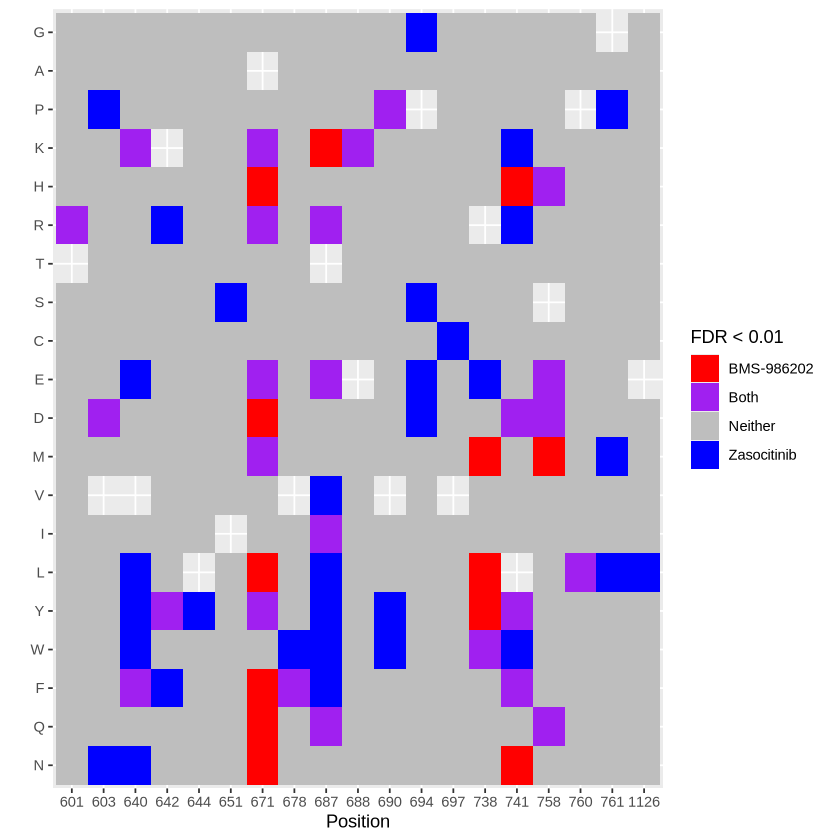

In [15]:
### Chemical Footprints

sumstats_resist <- contrast_sumstats %>%
    filter(assay == "assay2",
           condition %in% c("IFNalpha+Zasocitinib_1e-06", "IFNalpha+BMS-986202_1e-06"),
           aa %in% aa_order) %>%
    select(pos, condition, aa, statistic_contrast, fdr_contrast) %>%
    pivot_wider(names_from = condition, values_from = c(statistic_contrast, fdr_contrast)) %>%
    mutate(`FDR < 0.01` = case_when(`fdr_contrast_IFNalpha+BMS-986202_1e-06` < 0.01 & `fdr_contrast_IFNalpha+Zasocitinib_1e-06` < 0.01 ~ "Both",
                           `fdr_contrast_IFNalpha+BMS-986202_1e-06` < 0.01 & `fdr_contrast_IFNalpha+Zasocitinib_1e-06` > 0.01 ~ "BMS-986202",
                           `fdr_contrast_IFNalpha+BMS-986202_1e-06` > 0.01 & `fdr_contrast_IFNalpha+Zasocitinib_1e-06` < 0.01 ~ "Zasocitinib",
                           TRUE ~ "Neither"),
          `FDR < 0.01` = if_else(`statistic_contrast_IFNalpha+Zasocitinib_1e-06` < 0 & `statistic_contrast_IFNalpha+BMS-986202_1e-06` < 0,
                                 "Neither",
                                 `FDR < 0.01`),
          aa = if_else(aa %in% c("*", "X"), "*", aa),
          aa = factor(aa, levels = c("WT", aa_order)))

sig_positions_resist <- sumstats_resist %>% filter(`FDR < 0.01` != "Neither") %>% pull(pos) %>% unique()
prepped_data_resist <- sumstats_resist %>% filter(pos %in% sig_positions_resist)
names(prepped_data_resist) <- c("pos", "aa", "Z_BMS", "Z_ZASO",
                                "FDR_BMS", "FDR_ZASO", "FDR < 0.01")

plot_chemical_footprint(prepped_data_resist)

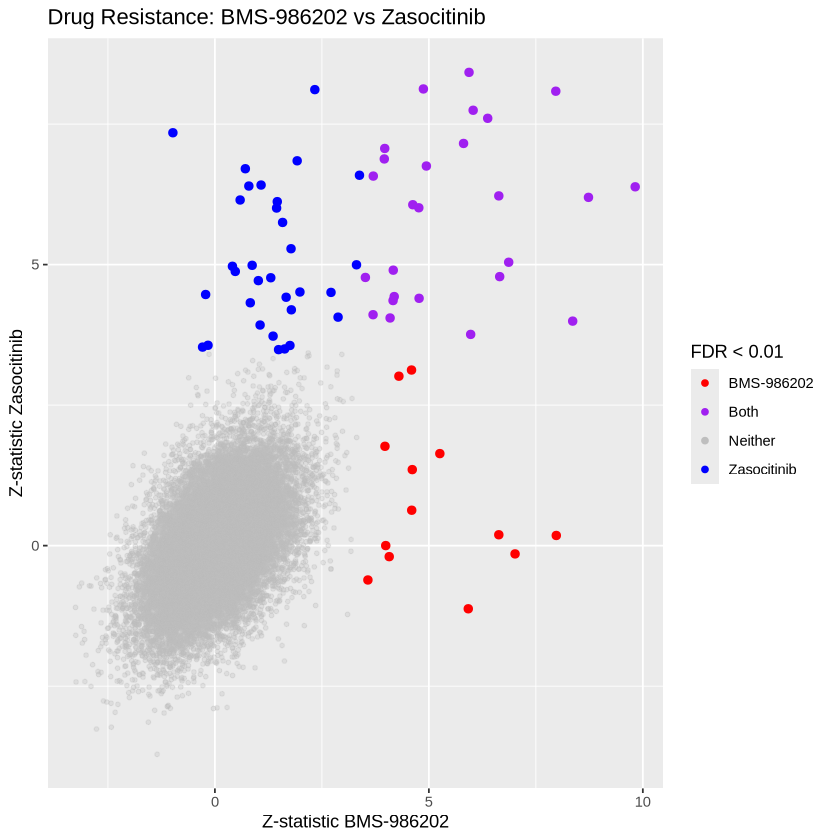

In [18]:
ggplot(sumstats_resist) +
    geom_point(aes(x = `statistic_contrast_IFNalpha+BMS-986202_1e-06`,
                   y = `statistic_contrast_IFNalpha+Zasocitinib_1e-06`,
                   color = `FDR < 0.01`,
                   size = if_else(`FDR < 0.01` == "Neither", 1, 2),
                   alpha = if_else(`FDR < 0.01` == "Neither", 0.3, 1))) +
    scale_color_manual(values = colors) +
    scale_size_identity() +
    scale_alpha_identity() +
    xlab("Z-statistic BMS-986202") + ylab("Z-statistic Zasocitinib") +
    ggtitle("Drug Resistance: BMS-986202 vs Zasocitinib")

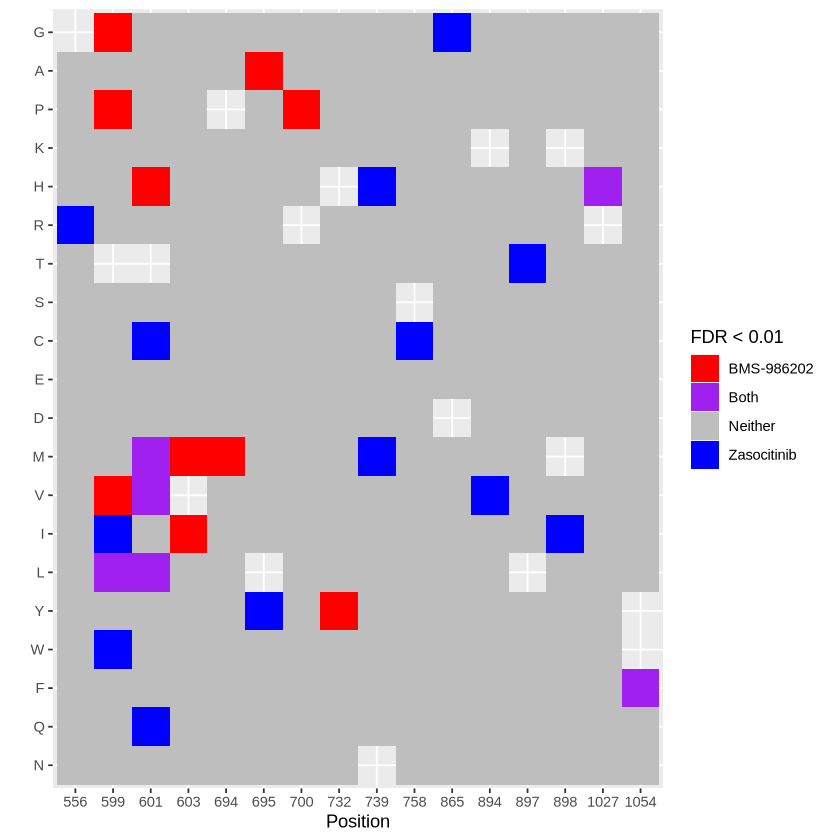

In [21]:
bms_poten <- compute_difference(test = "IFNalpha100+BMS-986202_2e-08",
                                control = "IFNalpha100_0",
                                assay3) 

zaso_poten <- compute_difference(test = "IFNalpha100+Zasocitinib_7e-09",
                                control = "IFNalpha100_0",
                                assay3) 

sumstats_potentiate <- bind_rows(bms_poten, zaso_poten) %>%
    mutate(statistic = log2FoldChange / log2StdError,
           p.value = (1 - pnorm(abs(statistic))) * 2,,
           FDR = p.adjust(p.value, method = "BH"),
           drug = gsub("_.*", "", condition)) %>%
    filter(aa %in% aa_order) %>%
    select(pos, drug, aa, statistic, FDR) %>%
    pivot_wider(names_from = drug, values_from = c(statistic, FDR)) %>%
    mutate("FDR < 0.01" = case_when(`FDR_IFNalpha100+BMS-986202` < 0.01 & `FDR_IFNalpha100+Zasocitinib` > 0.01 ~ "BMS-986202",
                               `FDR_IFNalpha100+BMS-986202` > 0.01 & `FDR_IFNalpha100+Zasocitinib` < 0.01 ~ "Zasocitinib",
                               `FDR_IFNalpha100+BMS-986202` < 0.01 & `FDR_IFNalpha100+Zasocitinib` < 0.01 ~ "Both",
                               TRUE ~ "Neither"),
           `FDR < 0.01` = if_else(`statistic_IFNalpha100+BMS-986202` > 0,
                                 "Neither",
                                 `FDR < 0.01`),
           aa = factor(aa, levels = aa_order))

sig_positions_potentiate <- sumstats_potentiate %>% filter(`FDR < 0.01` != "Neither") %>% pull(pos) %>% unique()
prepped_data_potentiate <- sumstats_potentiate %>% filter(pos %in% sig_positions_potentiate)
names(prepped_data_potentiate)<- c("pos", "aa", "Z_BMS", "Z_ZASO",
                                   "FDR_BMS", "FDR_ZASO", "FDR < 0.01")

plot_chemical_footprint(prepped_data_potentiate)

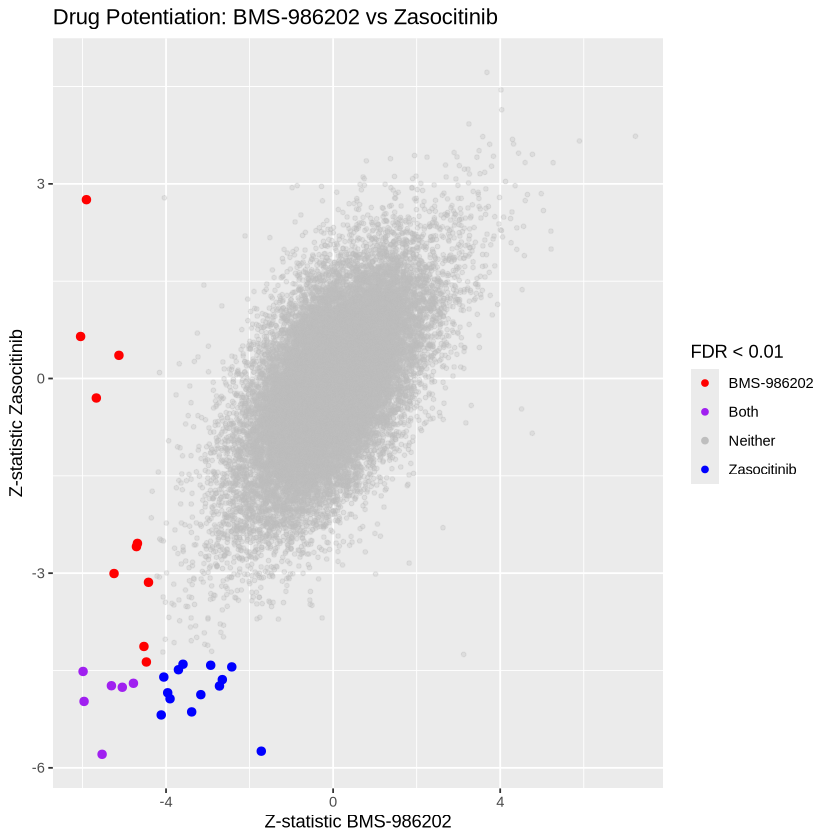

In [22]:
ggplot(sumstats_potentiate) +
    geom_point(aes(x = `statistic_IFNalpha100+BMS-986202`,
                   y = `statistic_IFNalpha100+Zasocitinib`,
                   color = `FDR < 0.01`,
                   size = if_else(`FDR < 0.01` == "Neither", 1, 2),
                   alpha = if_else(`FDR < 0.01` == "Neither", 0.3, 1))) +
    scale_color_manual(values = colors) +
    scale_size_identity() +
    scale_alpha_identity() +
    xlab("Z-statistic BMS-986202") + ylab("Z-statistic Zasocitinib") +
    ggtitle("Drug Potentiation: BMS-986202 vs Zasocitinib")

Hmm, okay I now have some of these positions that are putatively potentiating, or resistance. I guess it would be
interesting to see if those positions are similarly resistance at different drug doses

### explore resistanct residues

In [26]:
sumstats_resist_sig <- sumstats_resist |> filter(`FDR < 0.01` != "Neither")

In [37]:
sumstats_resist_sig |> head()

pos,aa,statistic_contrast_IFNalpha+BMS-986202_1e-06,statistic_contrast_IFNalpha+Zasocitinib_1e-06,fdr_contrast_IFNalpha+BMS-986202_1e-06,fdr_contrast_IFNalpha+Zasocitinib_1e-06,FDR < 0.01
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
642,F,-0.2165877,4.468085,9.810584e-01,2.797300e-04,Zasocitinib
642,R,0.7110156,6.705705,9.054516e-01,6.069350e-09,Zasocitinib
642,Y,4.8720021,8.125168,5.332713e-05,3.847693e-13,Both
687,E,4.1902283,4.431531,8.054197e-04,3.225777e-04,Both
687,F,0.7931958,6.397858,8.854814e-01,3.241549e-08,Zasocitinib
687,I,4.7650844,6.011002,8.329944e-05,2.453572e-07,Both


In [ ]:
contrast_sumstats |> head() # I think chunk is just the large groups of positions. then there is statistic, which is
# more or less just the z statistics that's being ploted in figure 1

chunk,pos,condition,aa,log2FoldChange,log2StdError,statistic,p.value,assay,fdr,log2FoldChange_Control,log2StdError_Control,log2Contrast,log2ContrastError,statistic_contrast,p.value_contrast,fdr_contrast
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,1051,IFNalpha_1,Stop,-0.32827896,0.5119714,-0.6412057,0.5213890442,assay1,0.83246901,0.5148870,0.5085672,-0.84316601,0.7216337,-1.16841266,0.242640353,0.77117824
16,1051,IFNalpha_10,Stop,-1.42526137,0.5963387,-2.3900198,0.0168474632,assay1,0.15664172,0.5148870,0.5085672,-1.94014841,0.7837477,-2.47547573,0.013305881,0.17362141
16,1051,IFNalpha_100,Stop,-1.91648342,0.5695281,-3.3650377,0.0007653319,assay1,0.01405539,0.5148870,0.5085672,-2.43137047,0.7635462,-3.18431348,0.001450978,0.02954594
16,1051,IFNalphaWithDrug_100,Stop,-0.16611366,0.5903476,-0.2813828,0.7784168280,assay1,0.93976436,0.5148870,0.5085672,-0.68100071,0.7791989,-0.87397544,0.382131630,0.86131371
16,1051,IFNbeta_100,Stop,0.49161868,0.4514839,1.0888952,0.2762000867,assay1,0.66716954,0.5148870,0.5085672,-0.02326836,0.6800576,-0.03421528,0.972705481,0.99692239
16,1051,IFNalpha_1,A,0.08283352,0.2762934,0.2998028,0.7643275941,assay1,0.93502902,0.3452057,0.2791116,-0.26237214,0.3927357,-0.66806297,0.504093400,0.91051558


In [ ]:
contrast_sumstats |> count(condition) 

# this is a lot more conditions thatn I expected. This si 

condition,n
<chr>,<int>
IFNalpha+BMS-986202_1e-06,23740
IFNalpha+BMS-986202_2e-08,23740
IFNalpha+BMS-986202_3.6e-09,23740
IFNalpha+Ropsacitinib_1e-07,23740
IFNalpha+Zasocitinib_1e-06,23740
IFNalpha100+BMS-986202_2e-08,23739
IFNalpha100+Ropsacitinib_1e-05,23739
IFNalpha100+Zasocitinib_7e-09,23739
IFNalpha100_0,23739


In [ ]:
resistance_sumstats <- sumstats_resist_sig |> left_join(contrast_sumstats, by = c("pos", "aa"))

In [46]:
resistance_sumstats |> colnames()

[1] "pos"                                          
 [2] "aa"                                           
 [3] "statistic_contrast_IFNalpha+BMS-986202_1e-06" 
 [4] "statistic_contrast_IFNalpha+Zasocitinib_1e-06"
 [5] "fdr_contrast_IFNalpha+BMS-986202_1e-06"       
 [6] "fdr_contrast_IFNalpha+Zasocitinib_1e-06"      
 [7] "FDR < 0.01"                                   
 [8] "chunk"                                        
 [9] "condition"                                    
[10] "log2FoldChange"                               
[11] "log2StdError"                                 
[12] "statistic"                                    
[13] "p.value"                                      
[14] "assay"                                        
[15] "fdr"                                          
[16] "log2FoldChange_Control"                       
[17] "log2StdError_Control"                         
[18] "log2Contrast"                                 
[19] "log2ContrastError"                            
[20] "statistic_contrast"                           
[21] "p.value_contrast"                             
[22] "fdr_contrast"

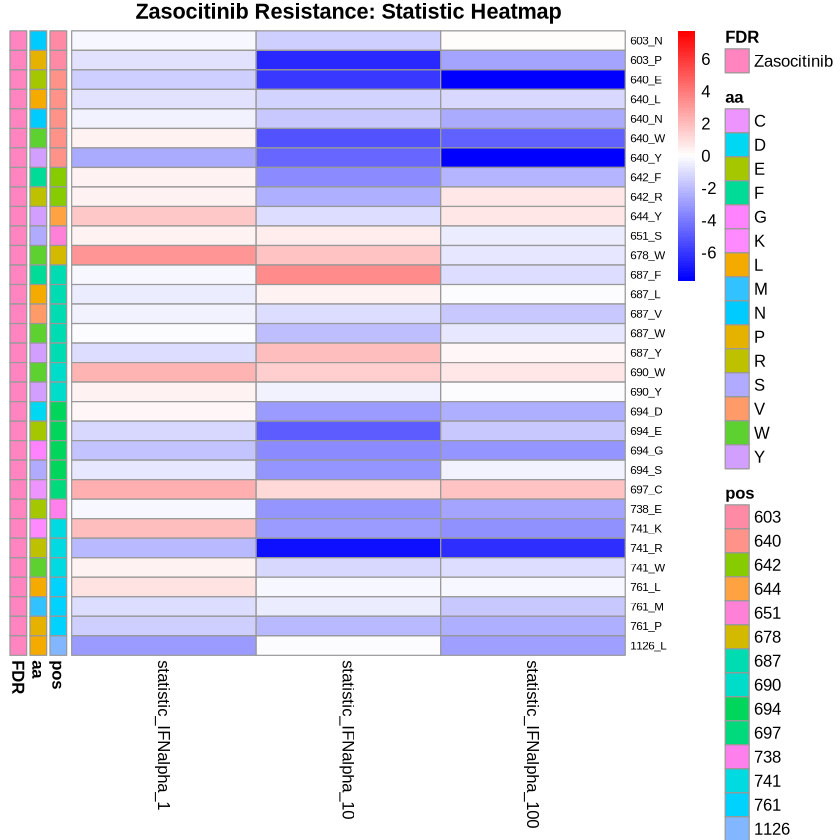

In [ ]:
# hmm, sanity check, we know that mutation for these positions change the drug response, but how do these look
# without drug? But I think 


# Visualize the statistics as a heatmap (no drug and drug conditions), annotated by pos, aa, and FDR < 0.01
library(pheatmap)

# Prepare matrix for heatmap: statistics under each relevant condition for significant resistant residues
# Sort by pos
heatmap_data <- resistance_sumstats |>
    filter(`FDR < 0.01` == "Zasocitinib") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)  # sort by pos

# Prepare the matrix and annotation
stat_matrix <- heatmap_data |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix) <- paste0(heatmap_data$pos, "_", heatmap_data$aa)

# Side annotation: data frame with pos, aa, FDR < 0.01
ann <- data.frame(
    pos = as.factor(heatmap_data$pos),
    aa = as.factor(heatmap_data$aa),
    FDR = heatmap_data$`FDR < 0.01`
)
rownames(ann) <- rownames(stat_matrix)

# Set color scale: blue for negative, white for zero, red for positive
color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

# Find the limits for color scale to center at 0
stat_min <- min(as.matrix(stat_matrix), na.rm = TRUE)
stat_max <- max(as.matrix(stat_matrix), na.rm = TRUE)
stat_lim <- max(abs(stat_min), abs(stat_max))

# Draw heatmap
pheatmap(
    mat = as.matrix(stat_matrix),
    annotation_row = ann,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "Zasocitinib Resistance: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette,
    breaks = seq(-stat_lim, stat_lim, length.out = 101)
)

# I mean, hmm, no these are all rather loss of fucntion variants. though weakly. 

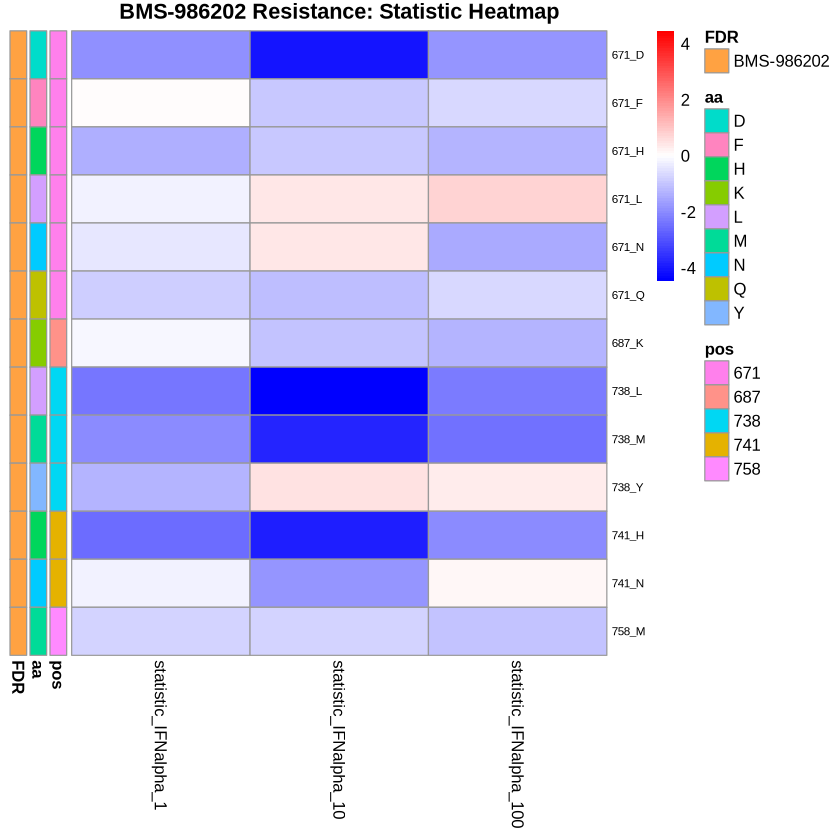

In [70]:
# Sort by pos
heatmap_data_bms <- resistance_sumstats |>
    filter(`FDR < 0.01` == "BMS-986202") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)  # sort by pos

# Prepare the matrix and annotation
stat_matrix_bms <- heatmap_data_bms |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix_bms) <- paste0(heatmap_data_bms$pos, "_", heatmap_data_bms$aa)

# Side annotation: data frame with pos, aa, FDR < 0.01
ann_bms <- data.frame(
    pos = as.factor(heatmap_data_bms$pos),
    aa = as.factor(heatmap_data_bms$aa),
    FDR = heatmap_data_bms$`FDR < 0.01`
)
rownames(ann_bms) <- rownames(stat_matrix_bms)

# Set color scale: blue for negative, white for zero, red for positive
color_palette_bms <- colorRampPalette(c("blue", "white", "red"))(100)

# Find the limits for color scale to center at 0
stat_min_bms <- min(as.matrix(stat_matrix_bms), na.rm = TRUE)
stat_max_bms <- max(as.matrix(stat_matrix_bms), na.rm = TRUE)
stat_lim_bms <- max(abs(stat_min_bms), abs(stat_max_bms))

# Draw heatmap
pheatmap(
    mat = as.matrix(stat_matrix_bms),
    annotation_row = ann_bms,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "BMS-986202 Resistance: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette_bms,
    breaks = seq(-stat_lim_bms, stat_lim_bms, length.out = 101)
)


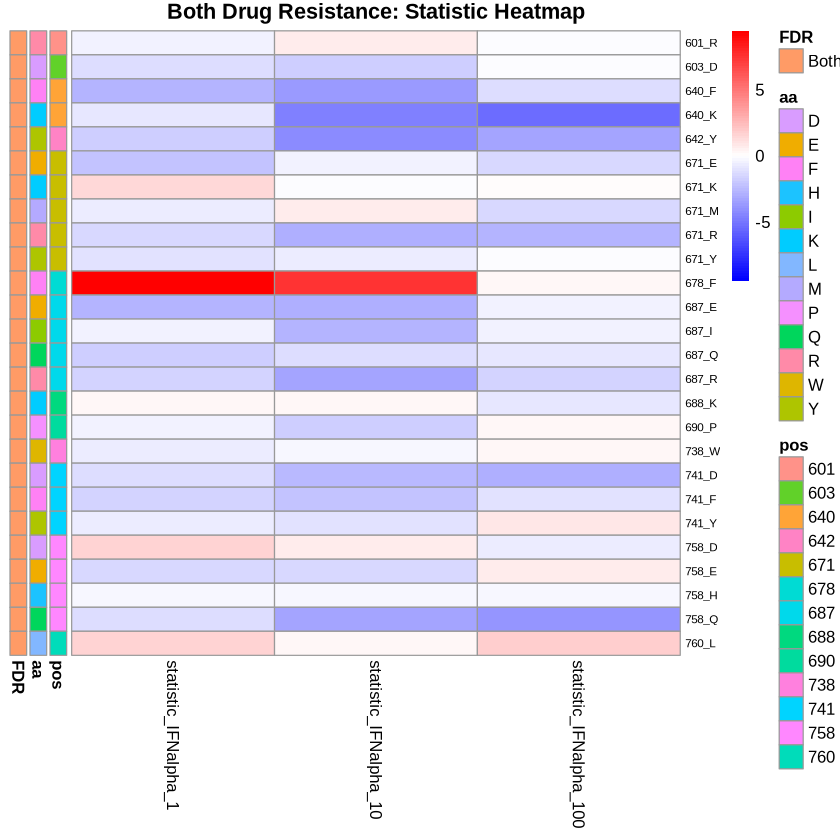

In [71]:
# Sort by pos
heatmap_data_both <- resistance_sumstats |>
    filter(`FDR < 0.01` == "Both") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)  # sort by pos

# Prepare the matrix and annotation
stat_matrix_both <- heatmap_data_both |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix_both) <- paste0(heatmap_data_both$pos, "_", heatmap_data_both$aa)

# Side annotation: data frame with pos, aa, FDR < 0.01
ann_both <- data.frame(
    pos = as.factor(heatmap_data_both$pos),
    aa = as.factor(heatmap_data_both$aa),
    FDR = heatmap_data_both$`FDR < 0.01`
)
rownames(ann_both) <- rownames(stat_matrix_both)

# Set color scale: blue for negative, white for zero, red for positive
color_palette_both <- colorRampPalette(c("blue", "white", "red"))(100)

# Find the limits for color scale to center at 0
stat_min_both <- min(as.matrix(stat_matrix_both), na.rm = TRUE)
stat_max_both <- max(as.matrix(stat_matrix_both), na.rm = TRUE)
stat_lim_both <- max(abs(stat_min_both), abs(stat_max_both))

# Draw heatmap
pheatmap(
    mat = as.matrix(stat_matrix_both),
    annotation_row = ann_both,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "Both Drug Resistance: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette_both,
    breaks = seq(-stat_lim_both, stat_lim_both, length.out = 101)
)


#### explor resistance residues in the context of abundance

In [ ]:
resistance_abundance <- sumstats_resist_sig |> left_join(flow_data, by = c("pos", "aa"))

In [74]:
resistance_abundance |> head()

pos,aa,statistic_contrast_IFNalpha+BMS-986202_1e-06,statistic_contrast_IFNalpha+Zasocitinib_1e-06,fdr_contrast_IFNalpha+BMS-986202_1e-06,fdr_contrast_IFNalpha+Zasocitinib_1e-06,FDR < 0.01,score_mean,score_se,chunk,WT score,WT score standard error,midpoint_shift,midpoint_shift_se,statistic,p.value,p.adj
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
642,F,-0.2165877,4.468085,9.810584e-01,2.797300e-04,Zasocitinib,0.2846884,0.03046979,10,0.6512205,0.00535871,-0.366532039,0.03093742,-11.8475295,0.000000e+00,0.000000e+00
642,R,0.7110156,6.705705,9.054516e-01,6.069350e-09,Zasocitinib,0.3261385,0.02342622,10,0.6512205,0.00535871,-0.325081919,0.02403130,-13.5274356,0.000000e+00,0.000000e+00
642,Y,4.8720021,8.125168,5.332713e-05,3.847693e-13,Both,0.2903328,0.03764480,10,0.6512205,0.00535871,-0.360887618,0.03802430,-9.4909744,0.000000e+00,0.000000e+00
687,E,4.1902283,4.431531,8.054197e-04,3.225777e-04,Both,0.5151742,0.11958686,10,0.6512205,0.00535871,-0.136046205,0.11970686,-1.1364946,2.557496e-01,5.999278e-01
687,F,0.7931958,6.397858,8.854814e-01,3.241549e-08,Zasocitinib,0.3972987,0.04831685,10,0.6512205,0.00535871,-0.253921764,0.04861310,-5.2233193,1.757439e-07,1.203666e-06
687,I,4.7650844,6.011002,8.329944e-05,2.453572e-07,Both,0.6593593,0.06516493,10,0.6512205,0.00535871,0.008138856,0.06538489,0.1244761,9.009383e-01,9.685138e-01


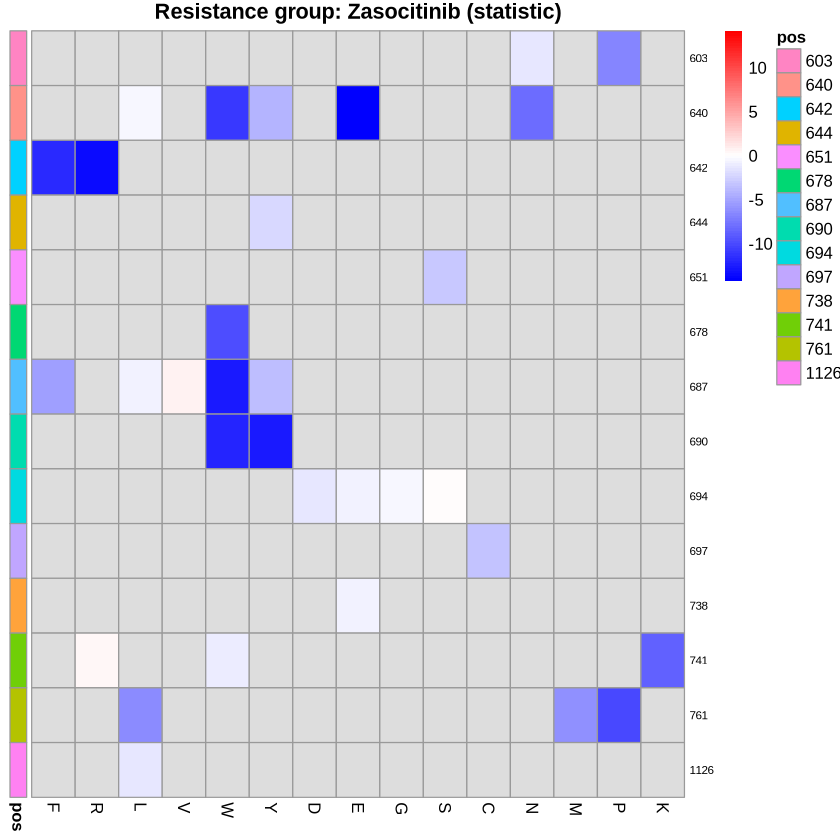

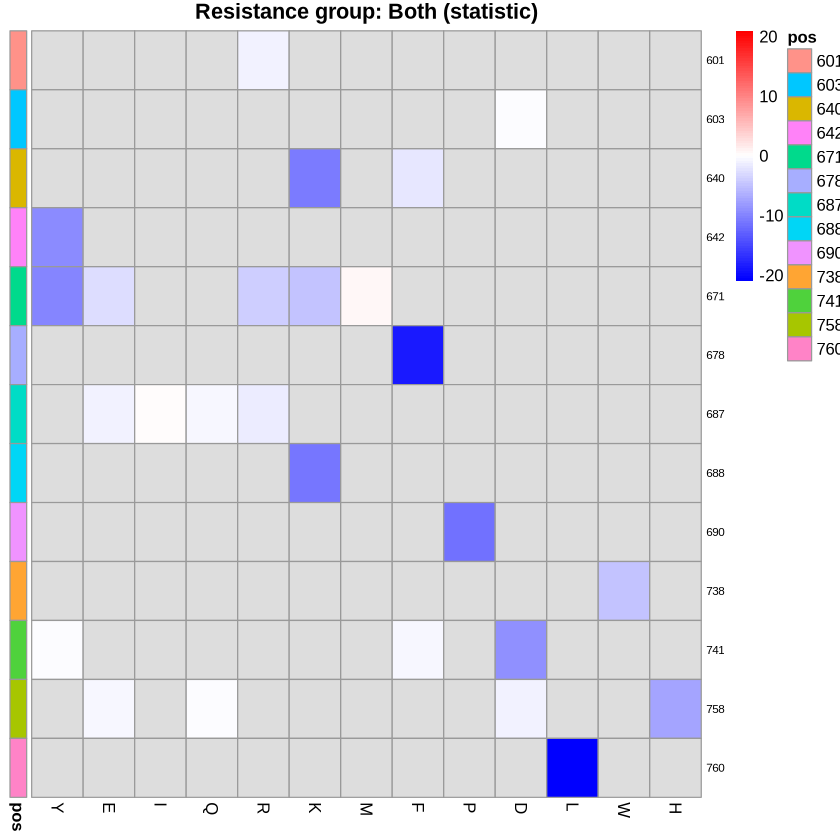

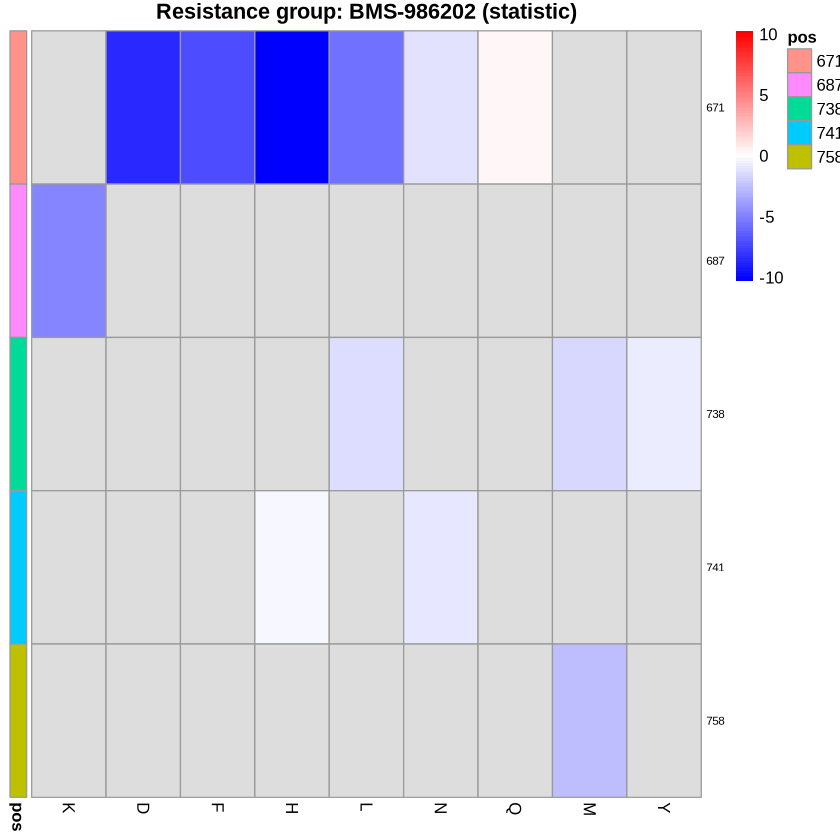

In [ ]:

# First, set up the matrix for each resistance group in "FDR < 0.01"
library(tidyr)

# Identify resistance groups
resistance_groups <- unique(resistance_abundance$`FDR < 0.01`)
resistance_groups <- resistance_groups[!is.na(resistance_groups)]

for (group in resistance_groups) {
    group_data <- resistance_abundance[resistance_abundance$`FDR < 0.01` == group, ]
    # Make a heatmap matrix: rows = pos, cols = aa, values = statistic (from sumstats)
    stat_matrix <- group_data |> 
        select(pos, aa, statistic) |> 
        pivot_wider(names_from = aa, values_from = statistic) |>
        arrange(pos)
    rownames_matrix <- stat_matrix$pos
    stat_matrix <- as.data.frame(stat_matrix)
    stat_matrix$pos <- NULL
    stat_matrix <- as.matrix(stat_matrix)
    rownames(stat_matrix) <- rownames_matrix

    # Set up annotation if you want, for now just using pos/aa
    ann <- data.frame(
        pos = as.factor(rownames_matrix)
    )
    rownames(ann) <- rownames_matrix

    # Blue-white-red scale centered on 0
    stat_min <- min(stat_matrix, na.rm=TRUE)
    stat_max <- max(stat_matrix, na.rm=TRUE)
    stat_lim <- max(abs(stat_min), abs(stat_max))
    color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

    pheatmap(
        mat = stat_matrix,
        annotation_row = ann,
        cluster_rows = FALSE,
        cluster_cols = FALSE,
        main = paste0("Resistance group: ", group, " (statistic)"),
        fontsize_row = 7,
        fontsize_col = 10,
        show_rownames = TRUE,
        show_colnames = TRUE,
        color = color_palette,
        breaks = seq(-stat_lim, stat_lim, length.out = 101)
    )
}

# hmm a lot of these are also strong abundance reducing? 



#### explore both together.

In [100]:
heatmap_data_both |> head()

pos,aa,FDR < 0.01.x,statistic_IFNalpha_1,statistic_IFNalpha_10,statistic_IFNalpha_100,statistic_contrast_IFNalpha+BMS-986202_1e-06,statistic_contrast_IFNalpha+Zasocitinib_1e-06,fdr_contrast_IFNalpha+BMS-986202_1e-06,fdr_contrast_IFNalpha+Zasocitinib_1e-06,⋯,score_mean,score_se,chunk,WT score,WT score standard error,midpoint_shift,midpoint_shift_se,statistic,p.value,p.adj
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
601,R,Both,-0.4326053,0.744438,-0.16033721,3.5164856,4.771655,0.008280039,8.146863e-05,⋯,0.5528126,0.10466076,9,0.6685729,0.007234816,-0.115760347,0.10491052,-1.103420,2.698449e-01,6.186739e-01
603,D,Both,-1.2670580,-1.753227,-0.03535325,3.7012198,6.575058,0.004539728,1.205194e-08,⋯,0.6602131,0.04782689,9,0.6685729,0.007234816,-0.008359864,0.04837100,-0.172828,8.627866e-01,9.562254e-01
603,N,Zasocitinib,-0.2961273,-1.402573,0.10043359,0.4096419,4.970265,0.959594050,3.511698e-05,⋯,0.5231392,0.12366899,9,0.6685729,0.007234816,-0.145433681,0.12388043,-1.173984,2.404013e-01,5.794552e-01
603,P,Zasocitinib,-0.8866604,-6.498425,-2.77435937,1.6646006,4.419131,0.507670787,3.391870e-04,⋯,0.2840064,0.05802309,9,0.6685729,0.007234816,-0.384566504,0.05847240,-6.576890,4.803913e-11,3.857116e-10
640,E,Zasocitinib,-1.4005639,-6.011779,-7.63127429,1.7790045,5.282473,0.444454638,8.719609e-06,⋯,0.3151718,0.02304252,10,0.6512205,0.005358710,-0.336048646,0.02365742,-14.204786,0.000000e+00,0.000000e+00
640,F,Both,-2.7511541,-3.707146,-1.25370700,3.9583962,6.879920,0.001872561,2.193951e-09,⋯,0.4665374,0.09621776,10,0.6512205,0.005358710,-0.184683068,0.09636687,-1.916458,5.530681e-02,2.015003e-01


In [103]:
head(heatmap_data_both)

pos,aa,FDR < 0.01.x,statistic_IFNalpha_1,statistic_IFNalpha_10,statistic_IFNalpha_100,statistic_contrast_IFNalpha+BMS-986202_1e-06,statistic_contrast_IFNalpha+Zasocitinib_1e-06,fdr_contrast_IFNalpha+BMS-986202_1e-06,fdr_contrast_IFNalpha+Zasocitinib_1e-06,⋯,score_mean,score_se,chunk,WT score,WT score standard error,midpoint_shift,midpoint_shift_se,statistic,p.value,p.adj
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
601,R,Both,-0.4326053,0.744438,-0.16033721,3.5164856,4.771655,0.008280039,8.146863e-05,⋯,0.5528126,0.10466076,9,0.6685729,0.007234816,-0.115760347,0.10491052,-1.103420,2.698449e-01,6.186739e-01
603,D,Both,-1.2670580,-1.753227,-0.03535325,3.7012198,6.575058,0.004539728,1.205194e-08,⋯,0.6602131,0.04782689,9,0.6685729,0.007234816,-0.008359864,0.04837100,-0.172828,8.627866e-01,9.562254e-01
603,N,Zasocitinib,-0.2961273,-1.402573,0.10043359,0.4096419,4.970265,0.959594050,3.511698e-05,⋯,0.5231392,0.12366899,9,0.6685729,0.007234816,-0.145433681,0.12388043,-1.173984,2.404013e-01,5.794552e-01
603,P,Zasocitinib,-0.8866604,-6.498425,-2.77435937,1.6646006,4.419131,0.507670787,3.391870e-04,⋯,0.2840064,0.05802309,9,0.6685729,0.007234816,-0.384566504,0.05847240,-6.576890,4.803913e-11,3.857116e-10
640,E,Zasocitinib,-1.4005639,-6.011779,-7.63127429,1.7790045,5.282473,0.444454638,8.719609e-06,⋯,0.3151718,0.02304252,10,0.6512205,0.005358710,-0.336048646,0.02365742,-14.204786,0.000000e+00,0.000000e+00
640,F,Both,-2.7511541,-3.707146,-1.25370700,3.9583962,6.879920,0.001872561,2.193951e-09,⋯,0.4665374,0.09621776,10,0.6512205,0.005358710,-0.184683068,0.09636687,-1.916458,5.530681e-02,2.015003e-01


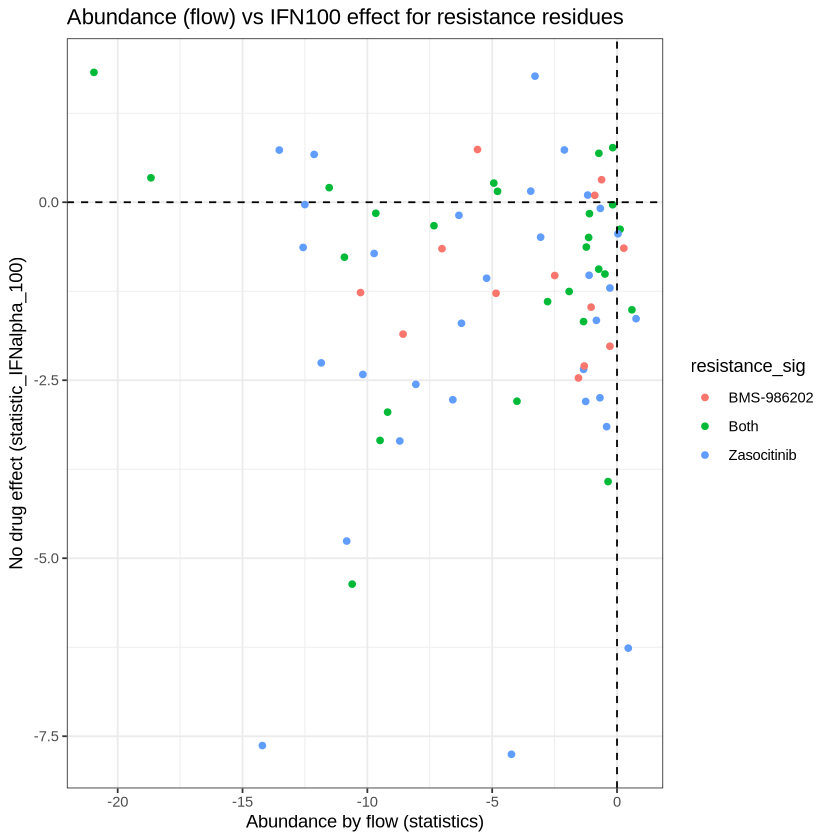

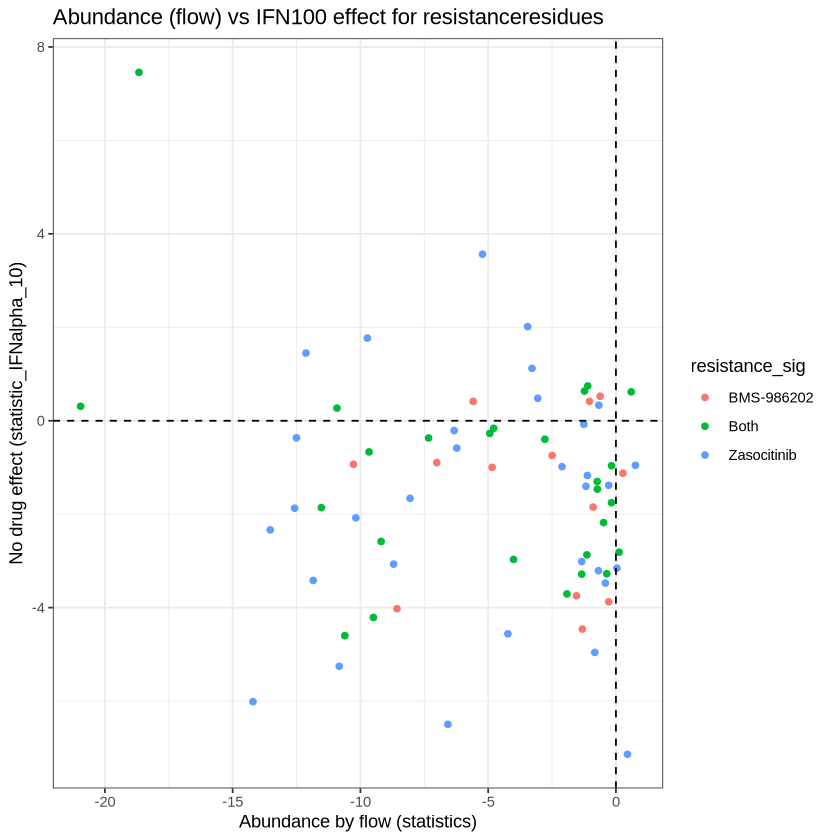

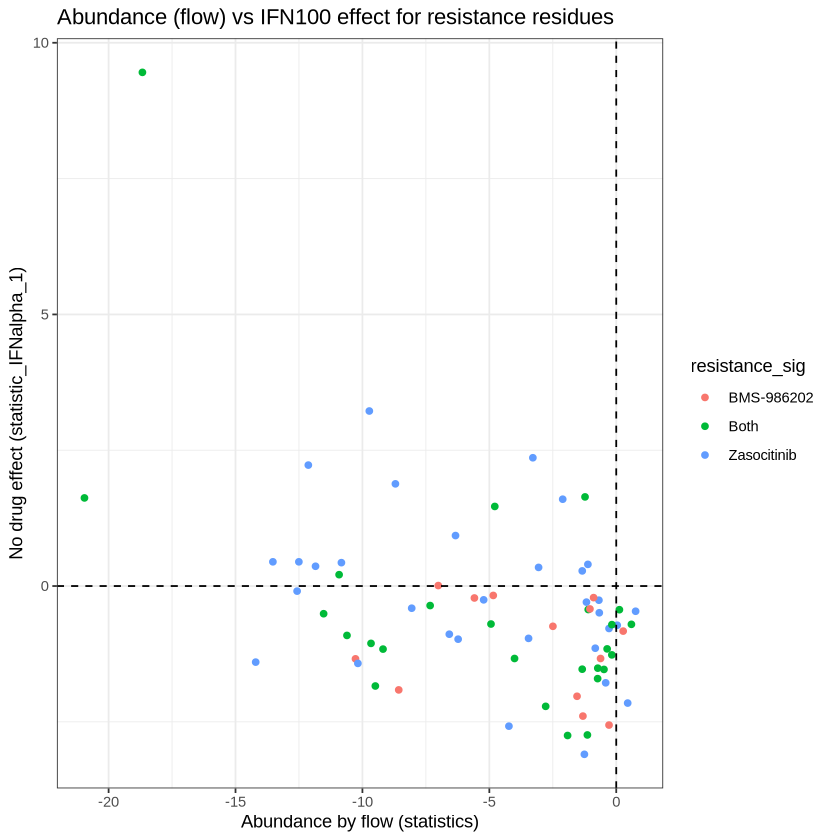

In [111]:
#
# resistance_abundance should have columns: pos, aa, abundance (or WT-normalized score or similar)
# Merge Zasocitinib-resisting variants with resistance_abundance
heatmap_data_both <- resistance_sumstats |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)|> left_join(resistance_abundance, by = c("pos", "aa")) |> rename(resistance_sig = `FDR < 0.01.x`)

# X: abundance by flow (from resistance_abundance, assuming column is named 'abundance')
# Y: statistic_IFNalpha_100 (change in statistics, no drug)

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_100,
    color = resistance_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_100)",
        title = "Abundance (flow) vs IFN100 effect for resistance residues"
    ) +
    theme_bw() +geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_10,
    color = resistance_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_10)",
        title = "Abundance (flow) vs IFN100 effect for resistanceresidues"
    ) +
    theme_bw()+geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_1,
    color = resistance_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_1)",
        title = "Abundance (flow) vs IFN100 effect for resistance residues"
    ) +
    theme_bw()+geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")






In [94]:
zaso_resist |> colnames()

[1] "pos"                                          
 [2] "aa"                                           
 [3] "statistic_IFNalpha100+BMS-986202"             
 [4] "statistic_IFNalpha100+Zasocitinib"            
 [5] "FDR_IFNalpha100+BMS-986202"                   
 [6] "FDR_IFNalpha100+Zasocitinib"                  
 [7] "FDR < 0.01.x"                                 
 [8] "chunk.x"                                      
 [9] "condition"                                    
[10] "log2FoldChange"                               
[11] "log2StdError"                                 
[12] "statistic.x"                                  
[13] "p.value.x"                                    
[14] "assay"                                        
[15] "fdr"                                          
[16] "log2FoldChange_Control"                       
[17] "log2StdError_Control"                         
[18] "log2Contrast"                                 
[19] "log2ContrastError"                            
[20] "statistic_contrast"                           
[21] "p.value_contrast"                             
[22] "fdr_contrast"                                 
[23] "statistic_contrast_IFNalpha+BMS-986202_1e-06" 
[24] "statistic_contrast_IFNalpha+Zasocitinib_1e-06"
[25] "fdr_contrast_IFNalpha+BMS-986202_1e-06"       
[26] "fdr_contrast_IFNalpha+Zasocitinib_1e-06"      
[27] "FDR < 0.01.y"                                 
[28] "score_mean"                                   
[29] "score_se"                                     
[30] "chunk.y"                                      
[31] "WT score"                                     
[32] "WT score standard error"                      
[33] "midpoint_shift"                               
[34] "midpoint_shift_se"                            
[35] "statistic.y"                                  
[36] "p.value.y"                                    
[37] "p.adj"

### potentiating residues

In [76]:
sumstats_potentiate_sig <- sumstats_potentiate |> filter(`FDR < 0.01` != "Neither")

In [78]:
potentiate_sumstats <- sumstats_potentiate_sig |> left_join(contrast_sumstats, by = c("pos", "aa"))

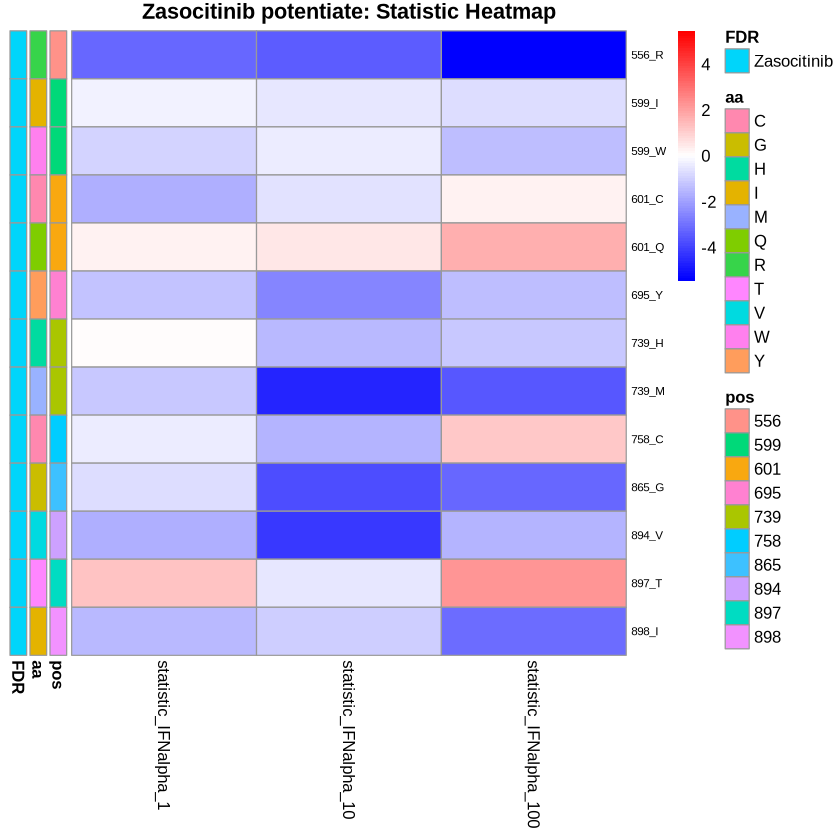

In [80]:
# hmm, sanity check, we know that mutation for these positions change the drug response, but how do these look
# without drug? But I think 


# Visualize the statistics as a heatmap (no drug and drug conditions), annotated by pos, aa, and FDR < 0.01
library(pheatmap)

# Prepare matrix for heatmap: statistics under each relevant condition for significant resistant residues
# Sort by pos
heatmap_data <- potentiate_sumstats |>
    filter(`FDR < 0.01` == "Zasocitinib") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)  # sort by pos

# Prepare the matrix and annotation
stat_matrix <- heatmap_data |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix) <- paste0(heatmap_data$pos, "_", heatmap_data$aa)

# Side annotation: data frame with pos, aa, FDR < 0.01
ann <- data.frame(
    pos = as.factor(heatmap_data$pos),
    aa = as.factor(heatmap_data$aa),
    FDR = heatmap_data$`FDR < 0.01`
)
rownames(ann) <- rownames(stat_matrix)

# Set color scale: blue for negative, white for zero, red for positive
color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

# Find the limits for color scale to center at 0
stat_min <- min(as.matrix(stat_matrix), na.rm = TRUE)
stat_max <- max(as.matrix(stat_matrix), na.rm = TRUE)
stat_lim <- max(abs(stat_min), abs(stat_max))

# Draw heatmap
pheatmap(
    mat = as.matrix(stat_matrix),
    annotation_row = ann,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "Zasocitinib potentiate: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette,
    breaks = seq(-stat_lim, stat_lim, length.out = 101)
)

# I mean, hmm, no these are all rather loss of fucntion variants. though weakly. 

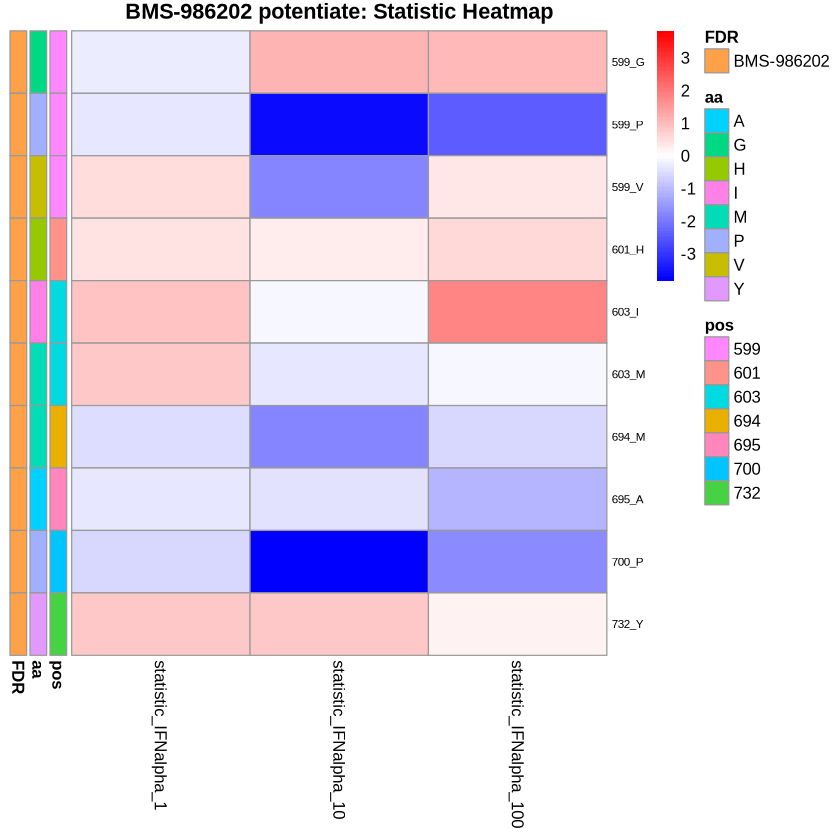

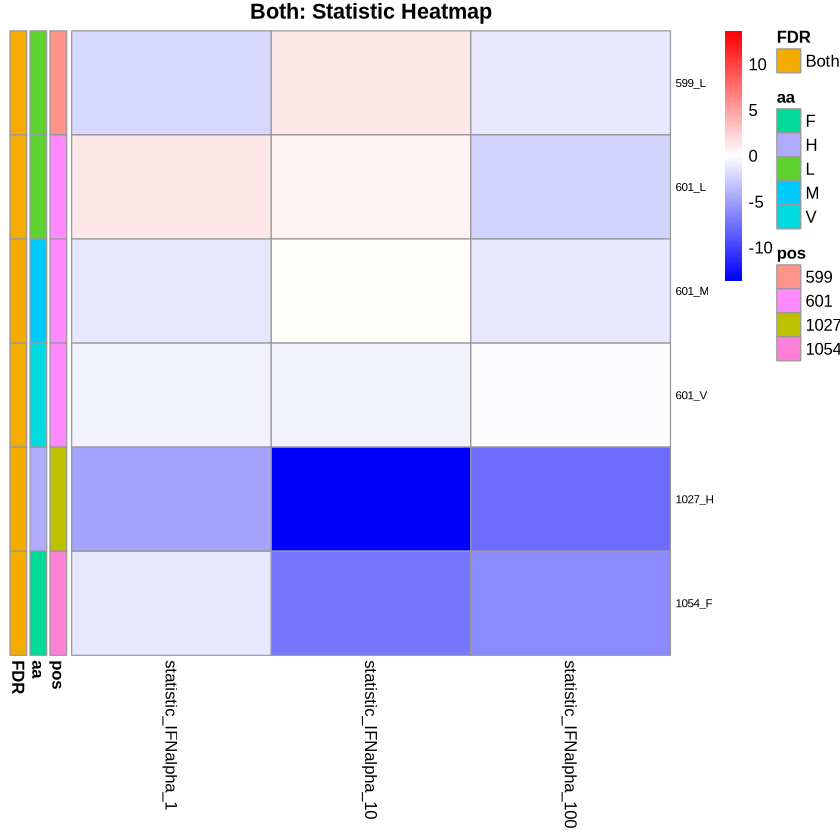

In [81]:
# Heatmap for BMS-986202 potentiate: Statistic Heatmap
heatmap_data_BMS <- potentiate_sumstats |>
    filter(`FDR < 0.01` == "BMS-986202") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)

stat_matrix_BMS <- heatmap_data_BMS |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix_BMS) <- paste0(heatmap_data_BMS$pos, "_", heatmap_data_BMS$aa)

ann_BMS <- data.frame(
    pos = as.factor(heatmap_data_BMS$pos),
    aa = as.factor(heatmap_data_BMS$aa),
    FDR = heatmap_data_BMS$`FDR < 0.01`
)
rownames(ann_BMS) <- rownames(stat_matrix_BMS)

stat_min_BMS <- min(as.matrix(stat_matrix_BMS), na.rm = TRUE)
stat_max_BMS <- max(as.matrix(stat_matrix_BMS), na.rm = TRUE)
stat_lim_BMS <- max(abs(stat_min_BMS), abs(stat_max_BMS))

pheatmap(
    mat = as.matrix(stat_matrix_BMS),
    annotation_row = ann_BMS,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "BMS-986202 potentiate: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette,
    breaks = seq(-stat_lim_BMS, stat_lim_BMS, length.out = 101)
)

# Heatmap for "Both" category potentiate: Statistic Heatmap
heatmap_data_both <- potentiate_sumstats |>
    filter(`FDR < 0.01` == "Both") |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)

stat_matrix_both <- heatmap_data_both |>
    select(starts_with("statistic")) |>
    as.data.frame()
rownames(stat_matrix_both) <- paste0(heatmap_data_both$pos, "_", heatmap_data_both$aa)

ann_both <- data.frame(
    pos = as.factor(heatmap_data_both$pos),
    aa = as.factor(heatmap_data_both$aa),
    FDR = heatmap_data_both$`FDR < 0.01`
)
rownames(ann_both) <- rownames(stat_matrix_both)

stat_min_both <- min(as.matrix(stat_matrix_both), na.rm = TRUE)
stat_max_both <- max(as.matrix(stat_matrix_both), na.rm = TRUE)
stat_lim_both <- max(abs(stat_min_both), abs(stat_max_both))

pheatmap(
    mat = as.matrix(stat_matrix_both),
    annotation_row = ann_both,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    main = "Both: Statistic Heatmap",
    fontsize_row = 7,
    fontsize_col = 10,
    show_rownames = TRUE,
    show_colnames = TRUE,
    color = color_palette,
    breaks = seq(-stat_lim_both, stat_lim_both, length.out = 101)
)


#### explore potentiating residues in abundance

In [82]:
potentiate_abundance <- sumstats_potentiate_sig |> left_join(flow_data, by = c("pos", "aa"))

In [83]:
potentiate_abundance |> head()

pos,aa,statistic_IFNalpha100+BMS-986202,statistic_IFNalpha100+Zasocitinib,FDR_IFNalpha100+BMS-986202,FDR_IFNalpha100+Zasocitinib,FDR < 0.01,score_mean,score_se,chunk,WT score,WT score standard error,midpoint_shift,midpoint_shift_se,statistic,p.value,p.adj
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
732,Y,-4.419810,-3.140963,0.008716579,2.054371e-01,BMS-986202,0.6286322,0.05462953,11,0.6585855,0.004981923,-0.029953272,0.05485623,-0.5460323,5.850437e-01,8.538593e-01
898,I,-3.702918,-4.488125,0.068837792,7.107129e-03,Zasocitinib,0.6672151,0.06009251,13,0.6446593,0.006792292,0.022555848,0.06047516,0.3729771,7.091655e-01,9.013444e-01
1054,F,-4.780424,-4.697037,0.003056230,3.580689e-03,Both,0.6549197,0.01847098,16,0.6465977,0.006408807,0.008322031,0.01955121,0.4256530,6.703607e-01,8.883982e-01
897,T,-3.593819,-4.403325,0.085477700,9.136619e-03,Zasocitinib,0.3416601,0.04081447,13,0.6446593,0.006792292,-0.302999174,0.04137579,-7.3231035,2.422507e-13,2.125676e-12
894,V,-2.652482,-4.640343,0.388291464,4.345881e-03,Zasocitinib,0.5565442,0.09374646,13,0.6446593,0.006792292,-0.088115041,0.09399220,-0.9374718,3.485159e-01,7.037021e-01
758,C,-1.719775,-5.743440,0.756685996,4.894032e-05,Zasocitinib,0.6461191,0.05650000,11,0.6585855,0.004981923,-0.012466413,0.05671921,-0.2197917,8.260334e-01,9.439163e-01


In [89]:
potentiate_groups

[1] "BMS-986202"  "Zasocitinib" "Both"

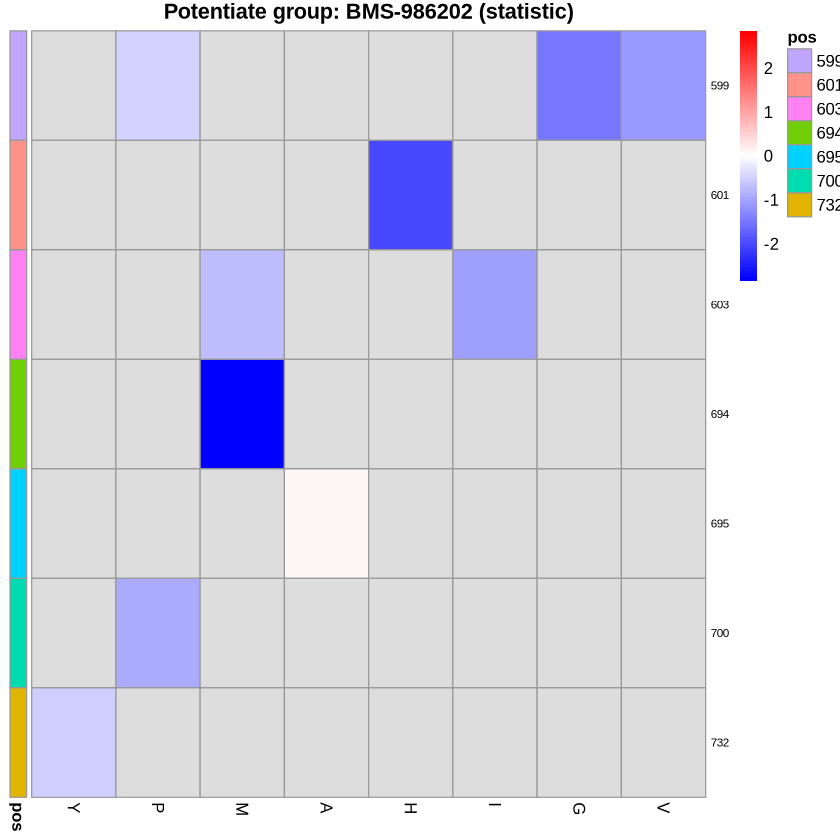

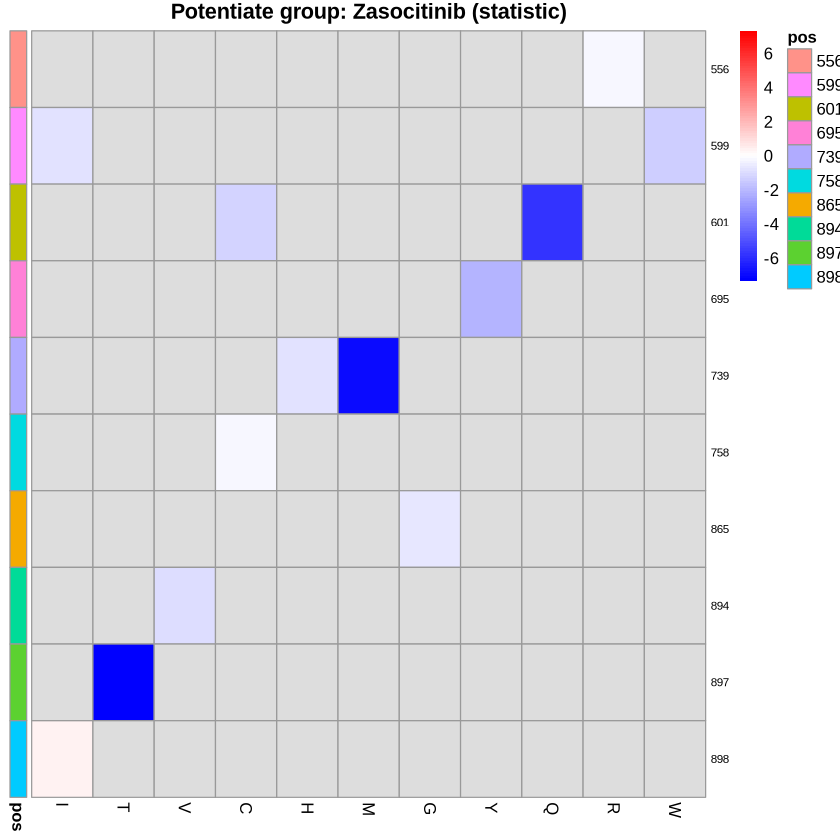

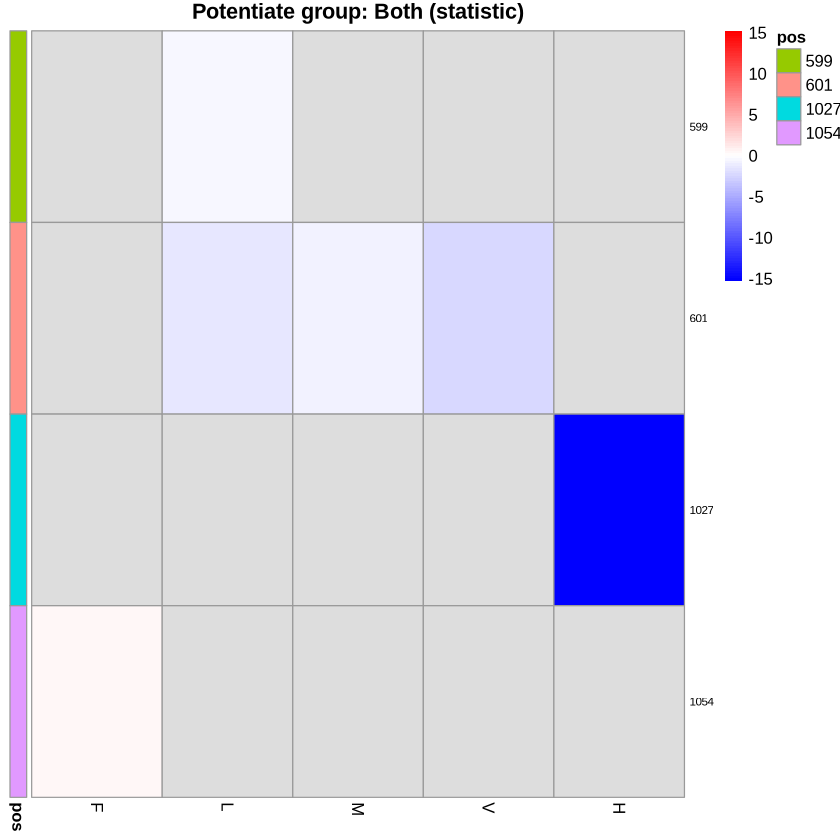

In [91]:

# First, set up the matrix for each resistance group in "FDR < 0.01"
library(tidyr)

# Identify resistance groups, remove NA
potentiate_groups <- unique(potentiate_abundance$`FDR < 0.01`)
potentiate_groups <- potentiate_groups[!is.na(potentiate_groups)]

for (group in potentiate_groups) {
    # FIX: potentiate_groups is just a character vector; need to subset potentiate_abundance!
    group_data <- potentiate_abundance[potentiate_abundance$`FDR < 0.01` == group, ]
    if (nrow(group_data) == 0) {
        message(paste("Skip group:", group, "- no data"))
        next
    }
    # Make a heatmap matrix: rows = pos, cols = aa, values = statistic (from sumstats)
    stat_matrix <- group_data |>
        select(pos, aa, statistic) |>
        pivot_wider(names_from = aa, values_from = statistic) |>
        arrange(pos)
    rownames_matrix <- stat_matrix$pos
    stat_matrix <- as.data.frame(stat_matrix)
    stat_matrix$pos <- NULL
    stat_matrix <- as.matrix(stat_matrix)
    rownames(stat_matrix) <- rownames_matrix

    # Set up annotation if you want, for now just using pos/aa
    ann <- data.frame(
        pos = as.factor(rownames_matrix)
    )
    rownames(ann) <- rownames_matrix

    # Blue-white-red scale centered on 0
    stat_min <- min(stat_matrix, na.rm=TRUE)
    stat_max <- max(stat_matrix, na.rm=TRUE)
    stat_lim <- max(abs(stat_min), abs(stat_max))
    color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

    tryCatch({
        pheatmap(
            mat = stat_matrix,
            annotation_row = ann,
            cluster_rows = FALSE,
            cluster_cols = FALSE,
            main = paste0("Potentiate group: ", group, " (statistic)"),
            fontsize_row = 7,
            fontsize_col = 10,
            show_rownames = TRUE,
            show_colnames = TRUE,
            color = color_palette,
            breaks = seq(-stat_lim, stat_lim, length.out = 101)
        )
    }, error = function(e) {
        message(sprintf("Error making heatmap for group '%s': %s", group, e$message))
    })
}

# hmm a lot of these are also strong abundance reducing? 



#### explore together

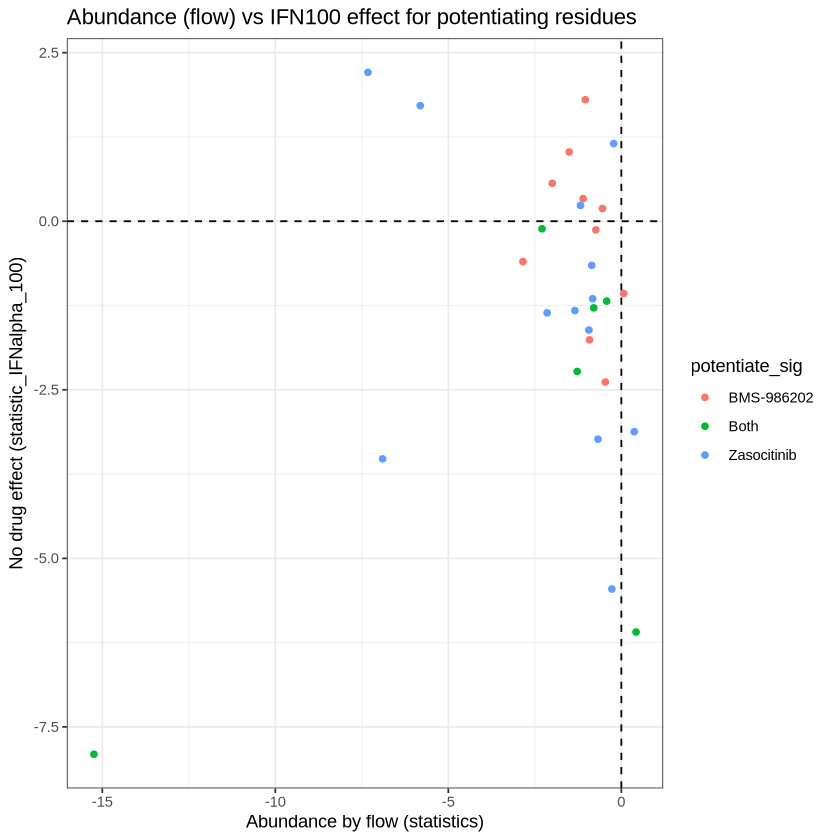

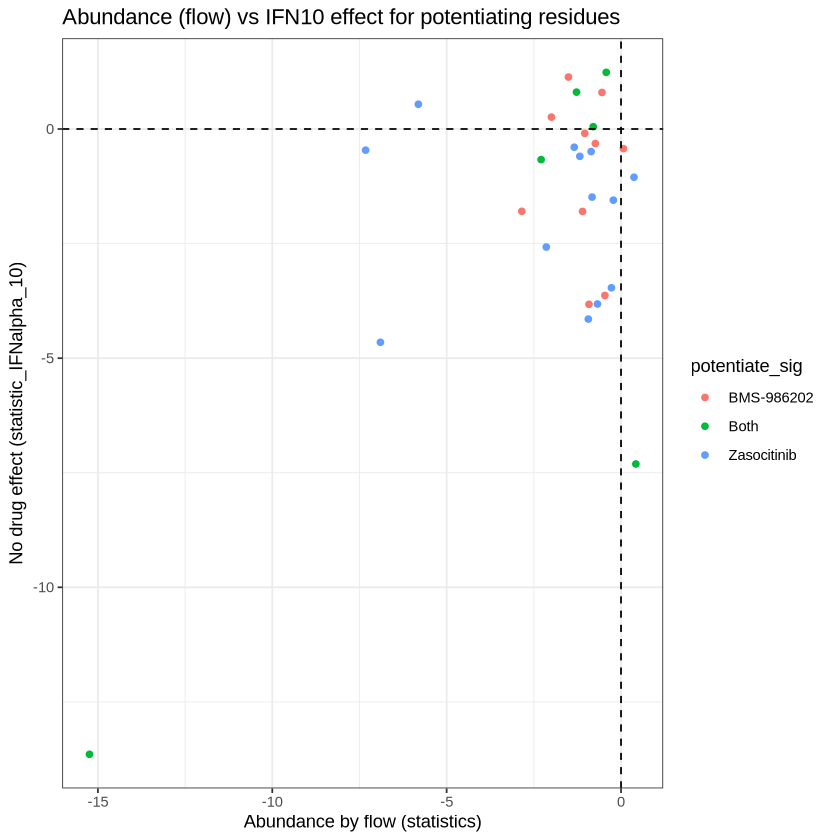

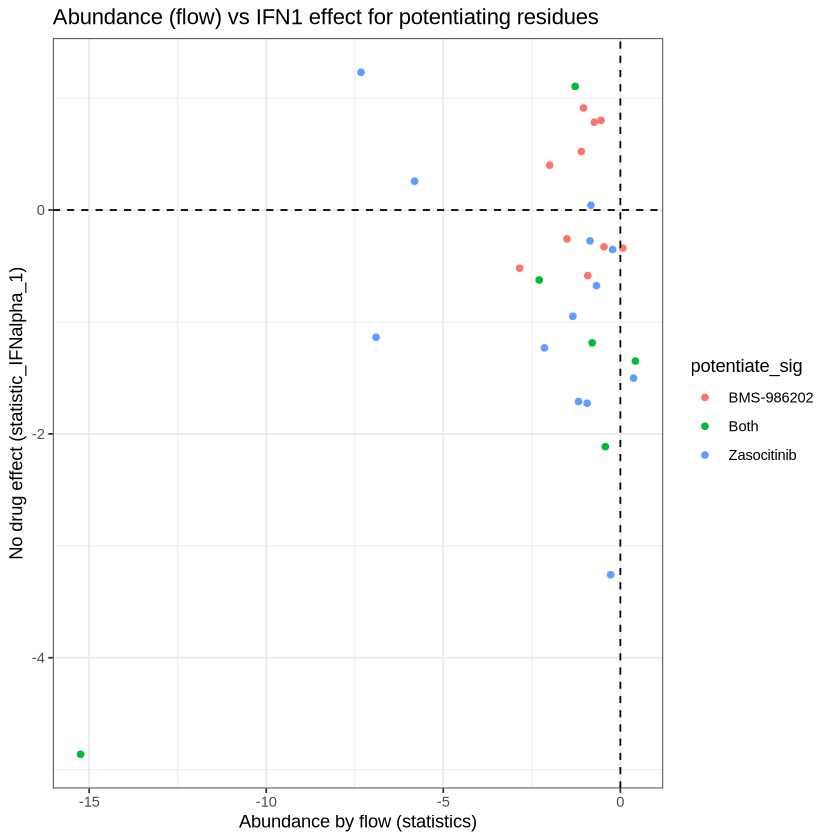

In [110]:
#
# resistance_abundance should have columns: pos, aa, abundance (or WT-normalized score or similar)
# Merge Zasocitinib-resisting variants with resistance_abundance
heatmap_data_both <- potentiate_sumstats |>
    select(pos, aa, `FDR < 0.01`, condition, statistic, log2FoldChange) |>
    pivot_wider(names_from = condition, values_from = c(statistic, log2FoldChange)) |>
    select(pos, aa, `FDR < 0.01`, `statistic_IFNalpha_1`, `statistic_IFNalpha_10`, `statistic_IFNalpha_100`) |>
    arrange(pos)|> left_join(potentiate_abundance, by = c("pos", "aa")) |> rename(potentiate_sig = `FDR < 0.01.x`)

# X: abundance by flow (from resistance_abundance, assuming column is named 'abundance')
# Y: statistic_IFNalpha_100 (change in statistics, no drug)

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_100,
    color = potentiate_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_100)",
        title = "Abundance (flow) vs IFN100 effect for potentiating residues"
    ) +
    theme_bw() +geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_10,
    color = potentiate_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_10)",
        title = "Abundance (flow) vs IFN10 effect for potentiating residues"
    ) +
    theme_bw()+geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")

ggplot(heatmap_data_both, aes(
    x = statistic,
    y = statistic_IFNalpha_1,
    color = potentiate_sig
)) +
    geom_point() +
    labs(
        x = "Abundance by flow (statistics)",
        y = "No drug effect (statistic_IFNalpha_1)",
        title = "Abundance (flow) vs IFN1 effect for potentiating residues"
    ) +
    theme_bw()+geom_hline(yintercept = 0, linetype = "dashed") +geom_vline(xintercept = 0, linetype = "dashed")






## conclusion

I'm not sure what we can really get from the data. It seems most number of the data are reducing activity in
some way. I guess it's not too surprising. but then where do I go from here.

There is a few snps that are increasing activity without drugs. and I think overall, i'm just seeing a lot of loss
of activities in all the mutational profiles.